In [72]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline
from imblearn.base import BaseEstimator

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_classification_report, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Data Importing

In [2]:
#import data train
df_train = pd.read_csv("kendaraan_train.csv").drop(columns="id")
df_train

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0
...,...,...,...,...,...,...,...,...,...,...,...
285826,Wanita,23.0,1.0,4.0,1.0,< 1 Tahun,Tidak,25988.0,152.0,217.0,0
285827,Wanita,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,44686.0,152.0,50.0,0
285828,Wanita,23.0,1.0,50.0,1.0,< 1 Tahun,Tidak,49751.0,152.0,226.0,0
285829,Pria,68.0,1.0,7.0,1.0,1-2 Tahun,Tidak,30503.0,124.0,270.0,0


In [3]:
#import data test
df_test = pd.read_csv("kendaraan_test.csv")
df_test

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,Wanita,49,1,8,0,1-2 Tahun,Pernah,46963,26,145,0
1,Pria,22,1,47,1,< 1 Tahun,Tidak,39624,152,241,0
2,Pria,24,1,28,1,< 1 Tahun,Tidak,110479,152,62,0
3,Pria,46,1,8,1,1-2 Tahun,Tidak,36266,124,34,0
4,Pria,35,1,23,0,1-2 Tahun,Pernah,26963,152,229,0
...,...,...,...,...,...,...,...,...,...,...,...
47634,Pria,61,1,46,0,> 2 Tahun,Pernah,31039,124,67,0
47635,Pria,41,1,15,0,1-2 Tahun,Pernah,2630,157,232,0
47636,Pria,24,1,29,1,< 1 Tahun,Tidak,33101,152,211,0
47637,Pria,59,1,30,0,1-2 Tahun,Pernah,37788,26,239,1


# Data Splitting

In [4]:
#split data train
X_train = df_train.drop(columns="Tertarik")
y_train = df_train.Tertarik

#split data test
X_test = df_test.drop(columns="Tertarik")
y_test = df_test.Tertarik

# Modeling

In [5]:
#class untuk menghandle outlier
class OutlierHandler(BaseEstimator):
    def fit(self, X, y):
        return self

    def fit_resample(self, X, y):
        for i in range(X.shape[1]):
            #hanya yang keunikan datanya lebih dari 2 yang diproses
            if len(np.unique(X[:, i])) <= 2:
                continue

            q1 = np.quantile(X[:, i], 0.25)  #quartil 1
            q3 = np.quantile(X[:, i], 0.75)  #quartil 3
            iqr = q3 - q1 #iqr
            
            #ubah outlier menjadi batas atas dan bawah
            X[:, i][np.argwhere(X[:, i] < q1 - iqr * 1.5)] = q1 - iqr * 1.5
            X[:, i][np.argwhere(X[:, i] > q3 + iqr * 1.5)] = q3 + iqr * 1.5
        return X, y

In [6]:
def evaluation(model):
    #fitting
    model.fit(X_train, y_train)

    #classification report
    plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

    #confussion matrix
    plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

## model 1

In [7]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median"), num_col), #memakai impute median
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     41778
           1       0.36      0.11      0.17      5861

    accuracy                           0.87     47639
   macro avg       0.62      0.54      0.55     47639
weighted avg       0.82      0.87      0.83     47639



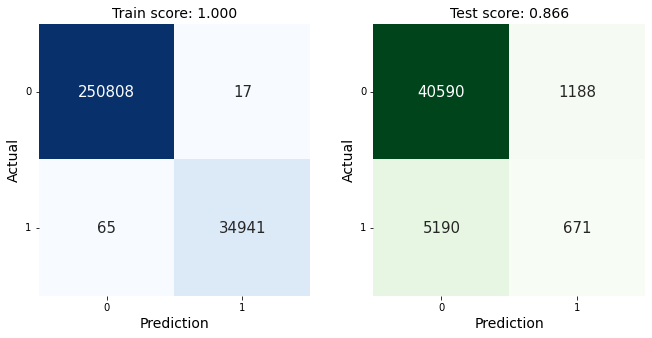

In [8]:
#preprocessor -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:43:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    250825
           1       0.74      0.03      0.07     35006

    accuracy                           0.88    285831
   macro avg       0.81      0.52      0.50    285831
weighted avg       0.86      0.88      0.83    285831


Test report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     41778
           1       0.45      0.02      0.04      5861

    accuracy                           0.88     47639
   macro avg       0.66      0.51      0.49     47639
weighted avg       0.83      0.88      0.82     47639



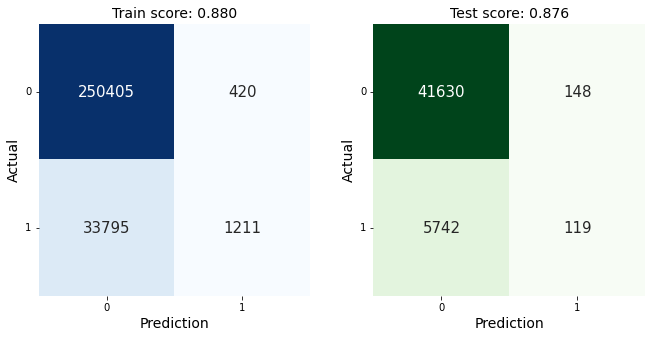

In [9]:
#preprocessor -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 2

In [10]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median"), num_col), #memakai impute median
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     41778
           1       0.33      0.23      0.27      5861

    accuracy                           0.85     47639
   macro avg       0.61      0.58      0.59     47639
weighted avg       0.83      0.85      0.84     47639



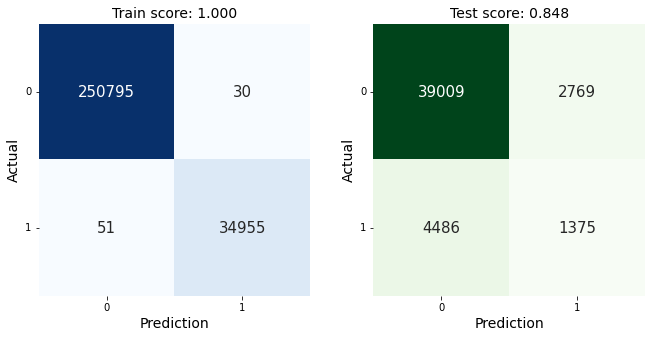

In [11]:
#preprocessor -> oversampling -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:46:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    250825
           1       0.48      0.08      0.14     35006

    accuracy                           0.88    285831
   macro avg       0.68      0.53      0.54    285831
weighted avg       0.84      0.88      0.84    285831


Test report
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     41778
           1       0.39      0.07      0.12      5861

    accuracy                           0.87     47639
   macro avg       0.64      0.53      0.53     47639
weighted avg       0.82      0.87      0.83     47639



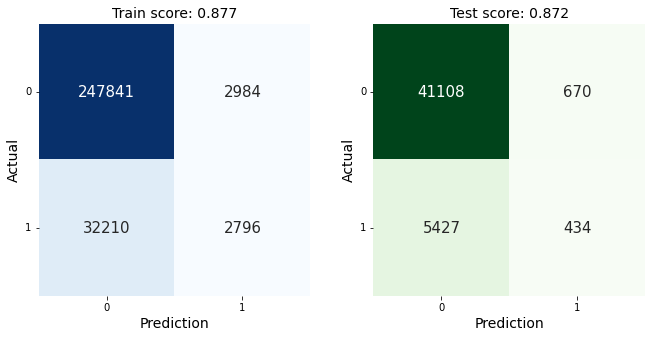

In [12]:
#preprocessor -> oversampling -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 3

In [13]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median"), num_col), #memakai impute median
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     41778
           1       0.36      0.12      0.18      5861

    accuracy                           0.87     47639
   macro avg       0.63      0.54      0.55     47639
weighted avg       0.82      0.87      0.83     47639



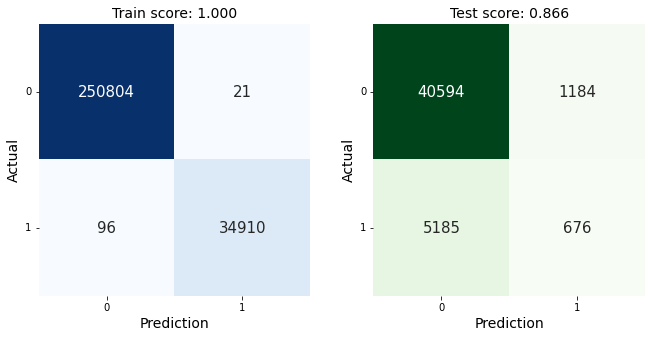

In [14]:
#preprocessor -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:48:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    250825
           1       0.74      0.04      0.07     35006

    accuracy                           0.88    285831
   macro avg       0.81      0.52      0.51    285831
weighted avg       0.86      0.88      0.83    285831


Test report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     41778
           1       0.47      0.02      0.04      5861

    accuracy                           0.88     47639
   macro avg       0.68      0.51      0.49     47639
weighted avg       0.83      0.88      0.82     47639



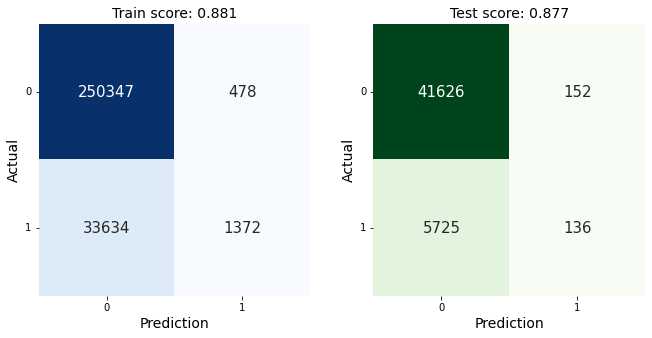

In [15]:
#preprocessor -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 4

In [16]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median"), num_col), #memakai impute median
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     41778
           1       0.34      0.25      0.29      5861

    accuracy                           0.85     47639
   macro avg       0.62      0.59      0.60     47639
weighted avg       0.83      0.85      0.84     47639



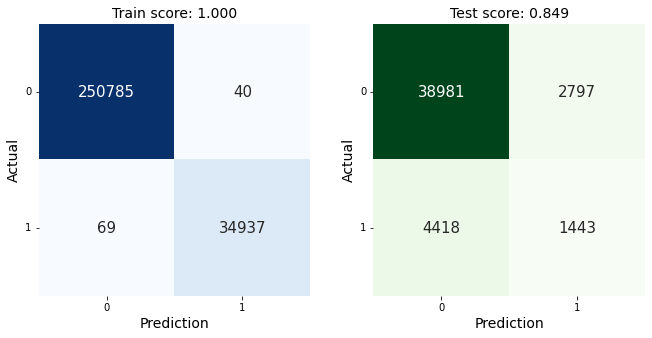

In [17]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:52:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    250825
           1       0.52      0.07      0.13     35006

    accuracy                           0.88    285831
   macro avg       0.70      0.53      0.53    285831
weighted avg       0.84      0.88      0.84    285831


Test report
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     41778
           1       0.40      0.06      0.11      5861

    accuracy                           0.87     47639
   macro avg       0.64      0.52      0.52     47639
weighted avg       0.82      0.87      0.83     47639



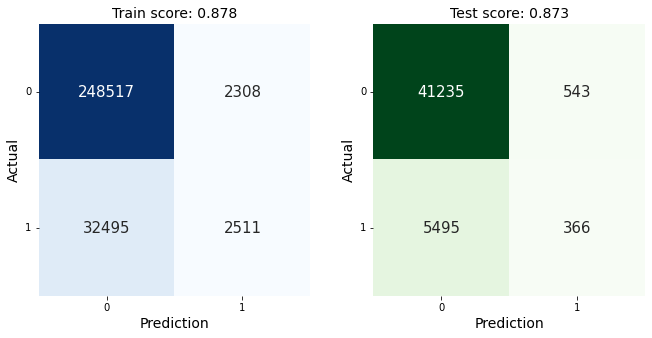

In [18]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 5

In [47]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median", scaling="minmax"), num_col), #memakai impute median & scaling minmax
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     41778
           1       0.32      0.40      0.36      5861

    accuracy                           0.82     47639
   macro avg       0.62      0.64      0.63     47639
weighted avg       0.84      0.82      0.83     47639



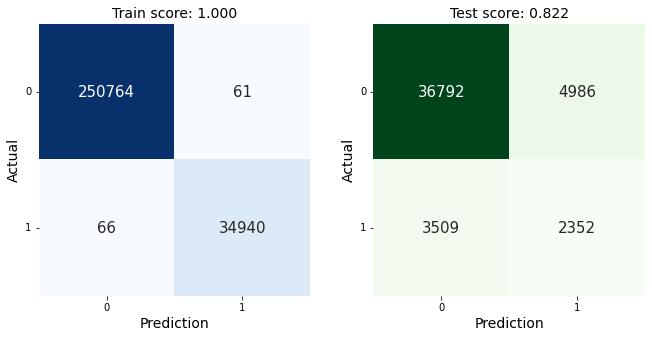

In [48]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:25:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.92      0.88      0.90    250825
           1       0.35      0.44      0.39     35006

    accuracy                           0.83    285831
   macro avg       0.63      0.66      0.65    285831
weighted avg       0.85      0.83      0.84    285831


Test report
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     41778
           1       0.34      0.44      0.38      5861

    accuracy                           0.83     47639
   macro avg       0.63      0.66      0.64     47639
weighted avg       0.85      0.83      0.84     47639



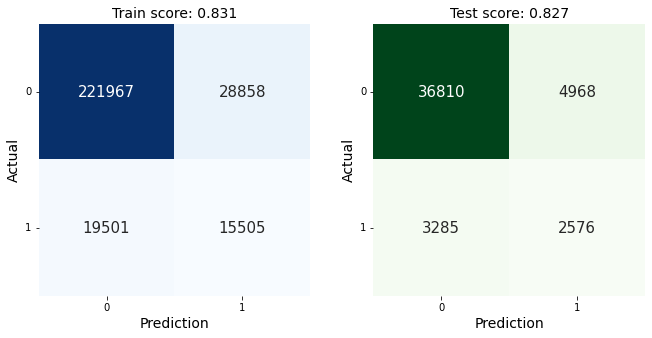

In [49]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 6

In [28]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median", scaling="robust"), num_col), #memakai impute median & scaling robust
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     41778
           1       0.32      0.32      0.32      5861

    accuracy                           0.83     47639
   macro avg       0.61      0.61      0.61     47639
weighted avg       0.83      0.83      0.83     47639



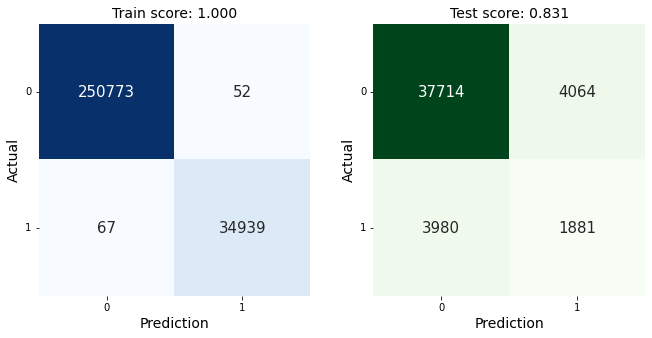

In [29]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:24:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92    250825
           1       0.38      0.32      0.35     35006

    accuracy                           0.85    285831
   macro avg       0.64      0.62      0.63    285831
weighted avg       0.84      0.85      0.85    285831


Test report
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     41778
           1       0.35      0.30      0.33      5861

    accuracy                           0.85     47639
   macro avg       0.63      0.61      0.62     47639
weighted avg       0.84      0.85      0.84     47639



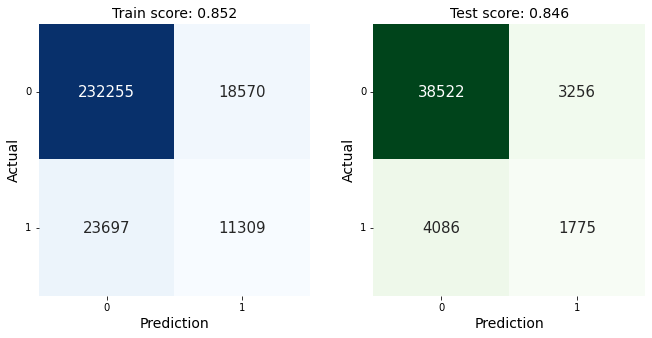

In [30]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 7

In [31]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median", scaling="minmax"), num_col), #memakai impute median & scaling minmax
    ("categoric", cat_pipe(impute="most_frequent", encoder="ordinal"), cat_col) #memakai impute modus & encoder ordinal
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     41778
           1       0.32      0.39      0.35      5861

    accuracy                           0.83     47639
   macro avg       0.62      0.64      0.63     47639
weighted avg       0.84      0.83      0.83     47639



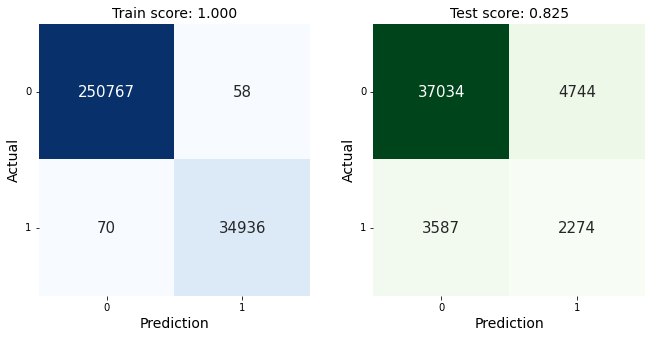

In [32]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:30:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.92      0.89      0.90    250825
           1       0.35      0.44      0.39     35006

    accuracy                           0.83    285831
   macro avg       0.64      0.66      0.65    285831
weighted avg       0.85      0.83      0.84    285831


Test report
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     41778
           1       0.34      0.43      0.38      5861

    accuracy                           0.83     47639
   macro avg       0.63      0.66      0.64     47639
weighted avg       0.85      0.83      0.84     47639



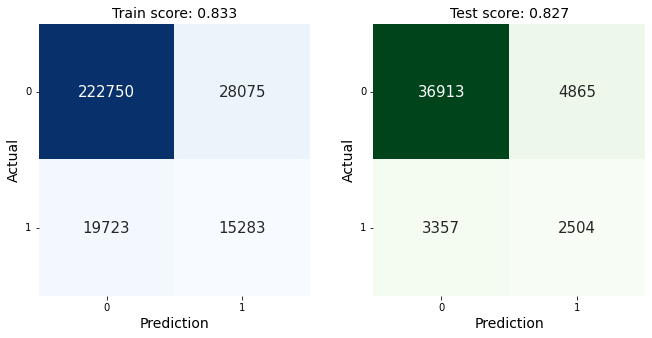

In [33]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 8

In [34]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median", scaling="minmax", poly=2), num_col), #memakai impute median & scaling minmax & poly 2
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     41778
           1       0.32      0.36      0.34      5861

    accuracy                           0.83     47639
   macro avg       0.62      0.63      0.62     47639
weighted avg       0.84      0.83      0.83     47639



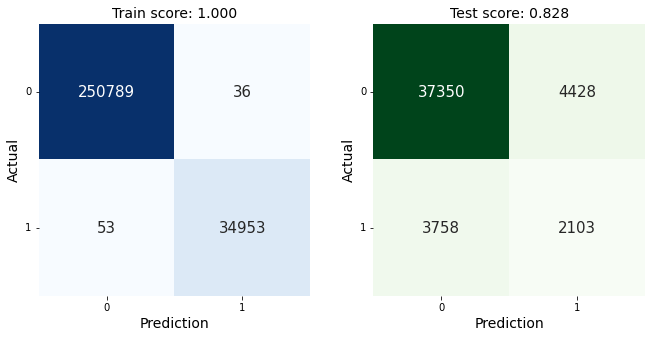

In [35]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:40:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.92      0.89      0.90    250825
           1       0.36      0.45      0.40     35006

    accuracy                           0.83    285831
   macro avg       0.64      0.67      0.65    285831
weighted avg       0.85      0.83      0.84    285831


Test report
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     41778
           1       0.34      0.43      0.38      5861

    accuracy                           0.83     47639
   macro avg       0.63      0.66      0.64     47639
weighted avg       0.85      0.83      0.84     47639



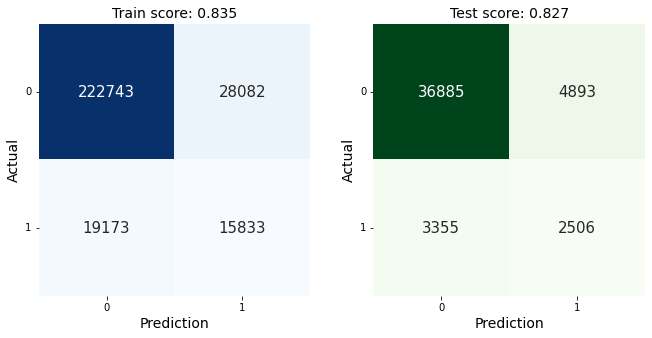

In [36]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 9

In [37]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median", scaling="minmax", poly=3), num_col), #memakai impute median & scaling minmax & poly 3
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     41778
           1       0.32      0.34      0.33      5861

    accuracy                           0.83     47639
   macro avg       0.61      0.62      0.62     47639
weighted avg       0.83      0.83      0.83     47639



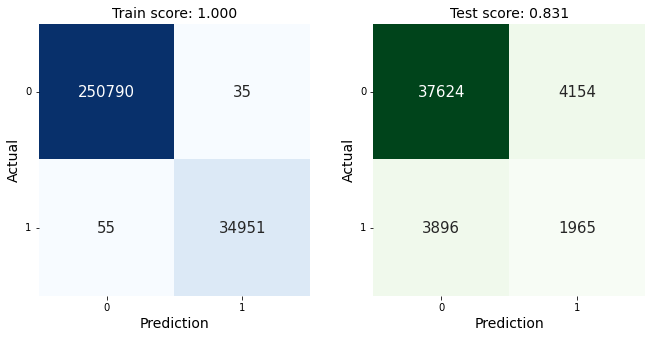

In [38]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.92      0.89      0.91    250825
           1       0.37      0.44      0.40     35006

    accuracy                           0.84    285831
   macro avg       0.64      0.67      0.65    285831
weighted avg       0.85      0.84      0.84    285831


Test report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     41778
           1       0.34      0.41      0.37      5861

    accuracy                           0.83     47639
   macro avg       0.63      0.65      0.64     47639
weighted avg       0.84      0.83      0.84     47639



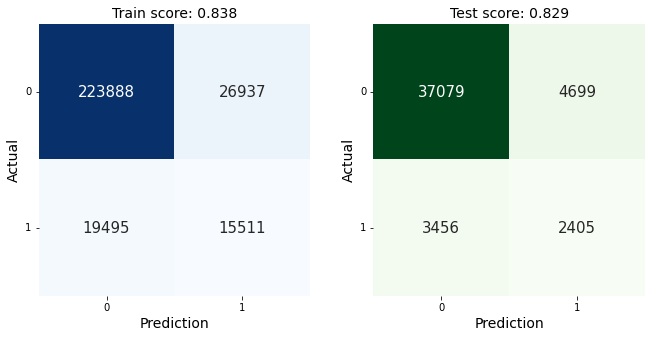

In [39]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 10

In [44]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median", scaling="minmax", transform="yeo-johnson"), num_col), #memakai impute median & scaling minmax & transform yeo-johnson
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


### random forest

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    250825
           1       1.00      1.00      1.00     35006

    accuracy                           1.00    285831
   macro avg       1.00      1.00      1.00    285831
weighted avg       1.00      1.00      1.00    285831


Test report
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     41778
           1       0.32      0.34      0.33      5861

    accuracy                           0.83     47639
   macro avg       0.61      0.62      0.62     47639
weighted avg       0.83      0.83      0.83     47639



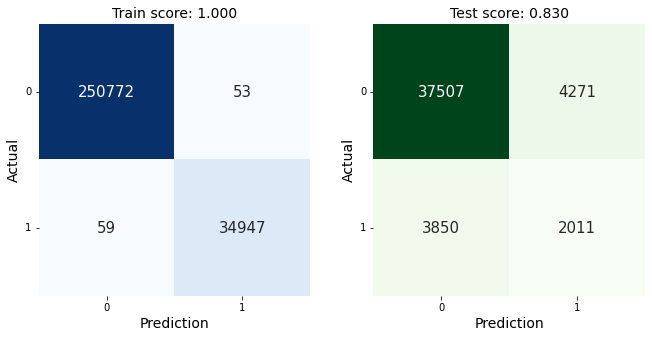

In [45]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:20:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.91      0.92      0.92    250825
           1       0.38      0.34      0.36     35006

    accuracy                           0.85    285831
   macro avg       0.64      0.63      0.64    285831
weighted avg       0.84      0.85      0.85    285831


Test report
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     41778
           1       0.36      0.33      0.34      5861

    accuracy                           0.84     47639
   macro avg       0.63      0.62      0.63     47639
weighted avg       0.84      0.84      0.84     47639



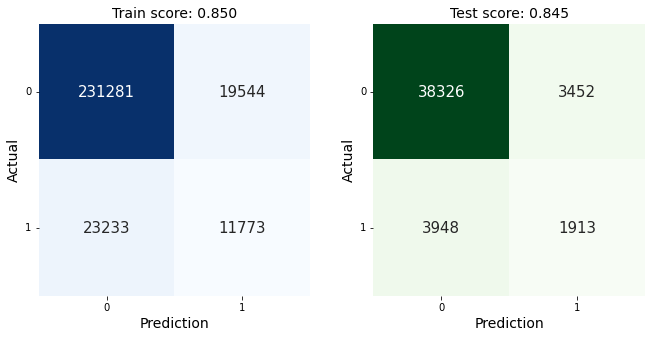

In [46]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 11

,feature,importance,stdev
6,Kendaraan_Rusak,0.007823,0.000357
5,Umur_Kendaraan,0.007346,0.000270
9,Lama_Berlangganan,0.003138,0.000227
1,Umur,0.002357,0.000593
7,Premi,0.002233,0.000319
0,Jenis_Kelamin,0.000099,0.000234
2,SIM,0.000000,0.000000
4,Sudah_Asuransi,0.000000,0.000000
3,Kode_Daerah,-0.004606,0.000271
8,Kanal_Penjualan,-0.010803,0.000176


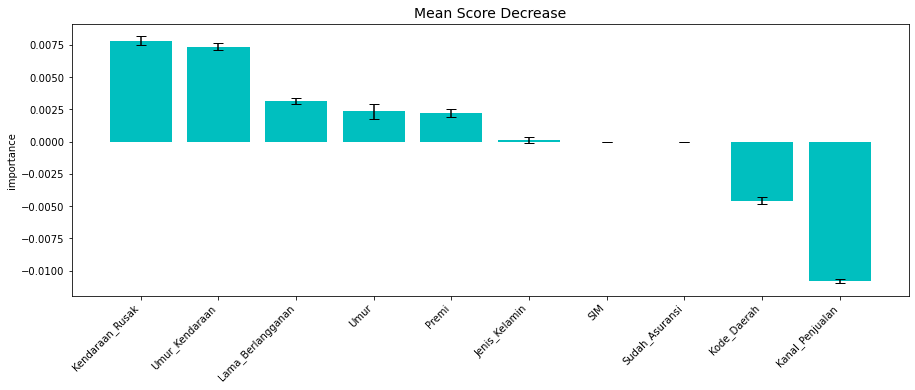

In [50]:
#feature selection berdasarkan model 5
mean_score_decrease(X_train, y_train, model, plot=True)

In [73]:
num_col = ["Umur", "Premi", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median", scaling="minmax"), num_col), #memakai impute median & scaling minmax
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

### random forest

Train report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    250825
           1       0.92      0.94      0.93     35006

    accuracy                           0.98    285831
   macro avg       0.96      0.96      0.96    285831
weighted avg       0.98      0.98      0.98    285831


Test report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     41778
           1       0.29      0.52      0.37      5861

    accuracy                           0.78     47639
   macro avg       0.60      0.67      0.62     47639
weighted avg       0.84      0.78      0.81     47639



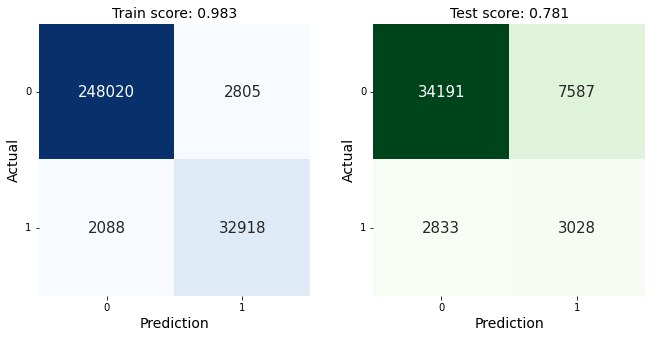

In [74]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:59:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.96      0.74      0.83    250825
           1       0.29      0.77      0.42     35006

    accuracy                           0.74    285831
   macro avg       0.63      0.76      0.63    285831
weighted avg       0.88      0.74      0.78    285831


Test report
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     41778
           1       0.29      0.76      0.42      5861

    accuracy                           0.75     47639
   macro avg       0.62      0.75      0.63     47639
weighted avg       0.87      0.75      0.79     47639



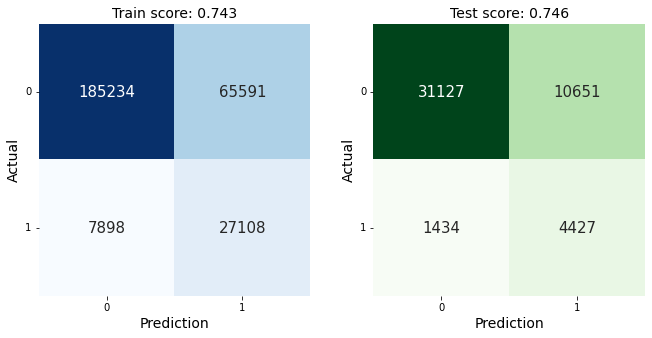

In [75]:
#preprocessor -> oversampling -> outlier handler -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

## model 12

In [68]:
num_col = ["Umur", "Kode_Daerah", "Premi", "Kanal_Penjualan", "Lama_Berlangganan"] #kolom numeric
cat_col = ["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Umur_Kendaraan", "Kendaraan_Rusak"] #kolom categoric

#membuat column preprosesor untuk menyatukan pipeline numeric dan categoric
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(impute="median", scaling="minmax"), num_col), #memakai impute median & scaling minmax
    ("categoric", cat_pipe(impute="most_frequent", encoder="onehot"), cat_col) #memakai impute modus & encoder onehot
])

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


### random forest

Train report
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    250825
           1       0.73      0.91      0.81     35006

    accuracy                           0.95    285831
   macro avg       0.86      0.93      0.89    285831
weighted avg       0.96      0.95      0.95    285831


Test report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     41778
           1       0.28      0.55      0.37      5861

    accuracy                           0.77     47639
   macro avg       0.60      0.68      0.61     47639
weighted avg       0.85      0.77      0.80     47639



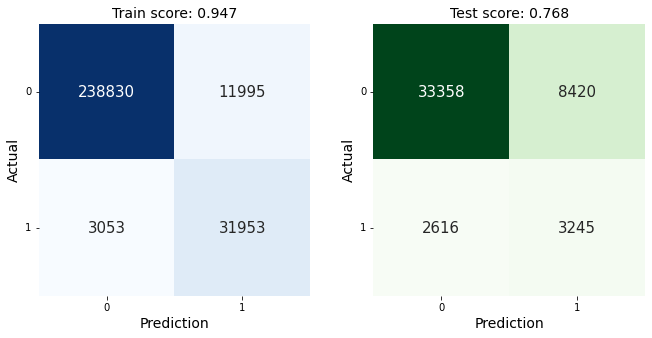

In [76]:
#preprocessor -> oversampling -> outlier handler -> PCA -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("pca", PCA(n_components=2, whiten=True)),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)

### xgboost

/home/galuhramaditya/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train report
              precision    recall  f1-score   support

           0       0.97      0.69      0.81    250825
           1       0.28      0.87      0.42     35006

    accuracy                           0.71    285831
   macro avg       0.63      0.78      0.61    285831
weighted avg       0.89      0.71      0.76    285831


Test report
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     41778
           1       0.28      0.84      0.42      5861

    accuracy                           0.72     47639
   macro avg       0.63      0.77      0.62     47639
weighted avg       0.88      0.72      0.77     47639



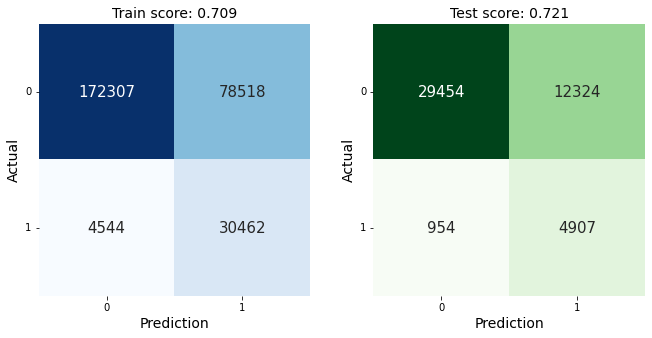

In [77]:
#preprocessor -> oversampling -> outlier handler -> PCA -> algoritma
model = Pipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=9)),
    ("outlier", OutlierHandler()),
    ("pca", PCA(n_components=2, whiten=True)),
    ("algo", XGBClassifier(n_jobs=-1, random_state=9))
])

#eval
evaluation(model)